## 35. Embedding（埋め込み法）

### <font color = blue>**1.** </font> 単語埋め込み (Word embeddings)

Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#### <font color = green> **1.1.** </font> 簡単な図解

##### テキストを数値で表す

機械学習モデルは、ベクトル（数値の配列）を入力として受け取ります。

テキストを扱う際、最初に決めなければならないのは、文字列を機械学習モデルに入力する前に、数値に変換する（あるいはテキストを「ベクトル化」する）ための戦略です。

このセクションでは、これを行う3つの戦略を見てみます。

##### ワンホット・エンコーディング

最初のアイデアとして、ボキャブラリの中の単語それぞれを「ワンホット」エンコードするというのがあります。

"The cat sat on the mat" という文を考えてみましょう。
 
この文に含まれるボキャブラリ（ユニークな単語）は、 (cat, mat, on, sat, the) です。
 
それぞれの単語を表現するため、ボキャブラリの長さに等しいゼロベクトルを作り、その単語に対応するインデックスの場所に 1 を立てます。

これを下図で示します。 

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

文をエンコードしたベクトルを作成するには、その後、それぞれの単語のワンホット・ベクトルをつなげればよいのです。

##### Key point: この手法は非効率です。
ワンホット・エンコードされたベクトルは疎（つまり、ほとんどのインデックスではゼロ）です。

ボキャブラリに 10,000 の単語があると考えてみましょう。

単語をすべてワンホット・エンコードするということは、要素の 99.99% がゼロであるベクトルを作ることになります。

##### それぞれの単語をユニークな数値としてエンコードする

2つ目のアプローチとして、それぞれの単語をユニークな数値でエンコードするというのがあります。

上記の例をとれば、"cat" に 1、"mat" に 2、というふうに番号を割り当てることができます。

そうすれば、 "The cat sat on the mat" という文は、 [5, 1, 4, 3, 5, 2] という密なベクトルで表すことができます。

この手法は効率的です。疎なベクトルの代わりに、密な（すべての要素が入っている）ベクトルが得られます。

しかしながら、このアプローチには 2つの欠点があります。

* 整数エンコーディングは勝手に決めたものです（単語間のいかなる関係性も含んでいません）。

* 整数エンコーディングはモデルにとっては解釈しにくいものです。たとえば、線形分類器はそれぞれの特徴量について単一の重みしか学習しません。したがって、2つの単語が似かよっていることと、それらのエンコーディングが似かよっていることの間には、なんの関係もありません。この特徴と重みの組み合わせには意味がありません。


##### 単語埋め込み

単語埋め込みを使うと、似たような単語が似たようにエンコードされる、効率的で密な表現が得られます。

重要なのは、このエンコーディングを手動で行う必要がないということです。

埋め込みは浮動小数点数の密なベクトルです（そのベクトルの長さはあなたが指定するパラメータです）。

埋め込みベクトルの値は指定するものではなく、学習されるパラメータです（モデルが密結合レイヤーの重みを学習するように、訓練をとおしてモデルが学習する重みです）。

一般的には、（小さいデータセットの場合の）8次元の埋め込みベクトルから、大きなデータセットを扱う 1024次元のものまで見られます。

高次元の埋め込みは単語間の細かな関係を取得できますが、学習にはよりたくさんのデータが必要です。

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>


上図は単語埋め込みを図示したものです。

それぞれの単語が 4次元の浮動小数点数のベクトルで表されています。

埋め込みは「参照テーブル」と考えることもできます。

重みが学習された後では、テーブルを参照して、それぞれの単語を対応する密ベクトルにエンコードできます。

#### <font color = green> **1.2.** </font> チュートリアルコード

In [ ]:
## 必要ライブラリのインストール等
!pip install tf-nightly
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

     |████████████████████████████████| 409.0MB 40kB/s 
     |████████████████████████████████| 471kB 41.4MB/s 
     |████████████████████████████████| 4.0MB 38.8MB/s 
     |████████████████████████████████| 4.0MB 37.6MB/s 
     |████████████████████████████████| 5.9MB 36.8MB/s 
     |████████████████████████████████| 3.8MB 33.5MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32

Embedding Layers 公式ドキュメント

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

In [ ]:
embedding_layer = layers.Embedding(1000,  # 入力データの最大次元数
                                   5  # 出力データ(embeddingした結果)の次元数
                                   )

# 埋め込み（重み）の初期値は（ほかのレイヤーとおなじように）ランダム
# 訓練を通じて、これらの重みは誤差逆伝搬によって徐々に調整される
# 学習された単語埋め込みは、単語の間の類似性をおおまかにコード化される

In [ ]:
# 整数を渡すと、結果はそれぞれの整数が埋め込みテーブルのベクトルに置き換えられる

result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.04960454,  0.01364697,  0.04547786,  0.03638072, -0.02447274],
       [ 0.03529087, -0.04131696, -0.01143914,  0.01581587, -0.04308077],
       [ 0.03108749, -0.04935341,  0.04237579,  0.02814522, -0.01249101]],
      dtype=float32)

In [ ]:
result.shape

TensorShape([3, 5])

In [ ]:
## テキストあるいはシーケンスの問題では、入力 shape が (samples, sequence_length) の2次元整数テンソルを取る
# 返されたテンソルは入力より 1つ軸が多くなっており、埋め込みベクトルはその最後の新しい軸に沿って並べられる
# (2, 3) の入力バッチを渡すと、出力は (2, 3, N) となる

result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

シーケンスのバッチを入力されると、Embedding レイヤーは shape が `(samples, sequence_length, embedding_dimensionality)` の3次元浮動小数点数テンソルを返します。

この可変長のシーケンスを、固定長の表現に変換するには、さまざまな標準的なアプローチが存在します。

Dense レイヤーに渡す前に、RNNやアテンション、プーリングレイヤーを使うことができます。

ここでは、一番単純なのでプーリングを使用します。

#### <font color = green> **1.3.** </font> IMDB の映画レビュー　データセット

https://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
## 前処理済みのデータセットを使用する

(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

# WARNING が出るが公式チュートリアルコードなので特に修正しない

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6AAHII/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6AAHII/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete6AAHII/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
## ボキャブラリを具体的に見てみる
# "_" は空白スペースを表している
# "_" で終わる単語全体と、長い単語を構成する文字列の一部が含まれている

encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [ ]:
train_data

<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [ ]:
## 映画のレビューはそれぞれ長さが異なっているはずなので、レビューの長さを標準化する

train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))

In [ ]:
## TensorFlow 2.2 から、padded_shapes は必須ではなくなりました
## デフォルトではすべての軸をバッチ中で最も長いものに合わせてパディングします

train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [ ]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

## インポートした状態では、レビューのテキストは整数エンコードされています
## （それぞれの整数がボキャブラリ中の特定の単語あるいは部分単語を表しています）
## あとの方のゼロは、バッチが一番長いサンプルに合わせてパディングされた結果です

array([[  12,  284,   14, ..., 7968, 8044, 7975],
       [4667, 5193,  124, ...,    0,    0,    0],
       [ 398,  198,   46, ...,    0,    0,    0],
       ...,
       [6169,  167, 7976, ...,    0,    0,    0],
       [ 693, 7037, 7961, ...,    0,    0,    0],
       [4555,  102,   11, ...,    0,    0,    0]])

#### <font color = green> **1.4.** </font> 単純なモデルで学習させてみる

In [ ]:
## 今回のモデルは「連続した Bag of Words」スタイルのモデルです

embedding_dim=16

model = keras.Sequential([
                          layers.Embedding(encoder.vocab_size, embedding_dim),
                          # 整数エンコードされた語彙を受け取り、それぞれの単語のインデックスに対応する埋め込みベクトルをみつけて取り出す
                          # これらのベクトルはモデルの訓練により学習される
                          # このベクトルは出力配列に次元を追加しその結果 (batch, sequence, embedding) という次元になる

                          layers.GlobalAveragePooling1D(),
                          # それぞれのサンプルについて、シーケンスの次元で平均を取り、固定長の出力ベクトルを返す
                          # これにより、モデルは可変長の入力を最も簡単な方法で扱えるようになる

                          # 固定長のベクトルが、16個の隠れユニットを持つ全結合（Dense）レイヤーに接続する
                          layers.Dense(16, activation='relu'),

                          layers.Dense(1)
                          # 1個の出力ノードを持つ Dense レイヤー
                          # シグモイド活性化関数を使うことで、値は 0 と 1 の間の値を取り、レビューがポジティブ（好意的）であるかどうかの確率（または確信度）を表す
                          ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
##########
# このモデルはマスキングを使用していないため、
# ゼロパディングが入力の一部として扱われ、
# 結果としてパディングの長さが出力に影響を与える可能性がある
##########

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches,
    validation_steps=20)

## 1エポック11秒前後、10エポックで計2分くらいかかる

Epoch 1/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.6149 - accuracy: 0.5792 - val_loss: 0.3332 - val_accuracy: 0.8400
Epoch 2/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.3009 - accuracy: 0.8725 - val_loss: 0.3512 - val_accuracy: 0.8650
Epoch 3/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2352 - accuracy: 0.9046 - val_loss: 0.3271 - val_accuracy: 0.8750
Epoch 4/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2031 - accuracy: 0.9228 - val_loss: 0.3537 - val_accuracy: 0.8800
Epoch 5/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1778 - accuracy: 0.9342 - val_loss: 0.3307 - val_accuracy: 0.8700
Epoch 6/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1568 - accuracy: 0.9424 - val_loss: 0.4528 - val_accuracy: 0.8500
Epoch 7/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.1418 - accuracy: 0.9485 - val_loss: 0.4110 - val_ac

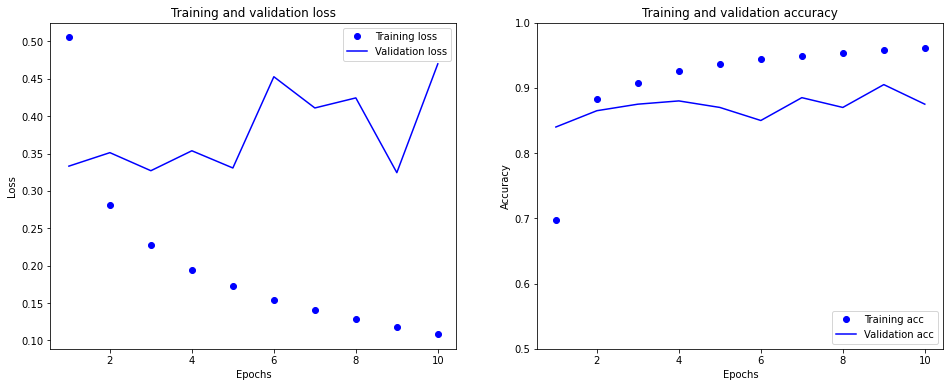

In [ ]:
## 可視化（subplotで横に並べて表示されるように改変した）

import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#plt.figure(figsize=(12,9))
plt.figure(figsize=(16,6))  ##
plt.subplot(1,2,1)  ##
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()

#plt.figure(figsize=(12,9))
plt.subplot(1,2,2)  ##
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

#### <font color = green> **1.5.** </font> 学習した埋め込みの取得

In [ ]:
## 訓練によって学習された単語埋め込みを取得してみる

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)

(8185, 16)


In [ ]:
## 重みをディスクに出力

import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # 0 はパディングのためスキップ
  out_m.write(word + "\n")  ## （単語を含む）メタデータファイル
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")  ## （埋め込みを含む）ベクトルのファイル
out_v.close()
out_m.close()

In [ ]:
## Colaboratory で実行している場合には、下記のコードを使ってこれらのファイルをローカルマシンにダウンロードすることができる

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### <font color = green> **1.6.** </font> 埋め込みを可視化する

埋め込みを可視化するため、1.5. でダウンロードした２つのファイルを Embedding Projector にアップロードします。

[Embedding Projector](http://projector.tensorflow.org/) を開きます。

* "Load data" をクリックします

* 作成した```vecs.tsv``` と ```meta.tsv``` の 2つのファイルをアップロードします


学習させた埋め込みが表示されます。

単語を探し、最も近い単語を見つけることができます。

たとえば、"beautiful" という単語を探してみてください。

近くに、 "wonderful" のような単語が見つかると思います。

**Note:** 訓練の前に重みが乱数によってどのように初期化されたかによって、結果は少し異なるかもしれません。

**Note:** 実験として、もっと単純なモデルを使い、より解釈しやすい埋め込みを作ることもできます。

`Dense(16)` レイヤーを削除してみてください。

このモデルを再度訓練して、埋め込みの可視化をもう一度行ってみましょう。


In [ ]:
## 以下コピペ改変用

embedding_dim2 = 16

model2 = keras.Sequential([
                          layers.Embedding(encoder.vocab_size, embedding_dim2),
                          layers.GlobalAveragePooling1D(),
                          #layers.Dense(16, activation='relu'),
                          layers.Dense(1)
                          ])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches,
    validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.6709 - accuracy: 0.5110 - val_loss: 0.5783 - val_accuracy: 0.7050
Epoch 2/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4962 - accuracy: 0.7324 - val_loss: 0.4443 - val_accuracy: 0.8400
Epoch 3/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3752 - accuracy: 0.8303 - val_loss: 0.4056 - val_accuracy: 0.8500
Epoch 4/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.3146 - accuracy: 0.8695 - val_loss: 0.3980 - val_accuracy: 0.8400
Epoch 5/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2767 - accuracy: 0.8901 - val_loss: 0.2924 - val_accuracy: 0.8500
Epoch 6/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2523 - accuracy: 0.9029 - val_loss: 0.4080 - val_accuracy: 0.8400
Epoch 7/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.2317 - accuracy: 0.9108 - val_loss: 0.4463 - val_ac

In [ ]:
## 重みをディスクに出力

encoder = info.features['text'].encoder

e2 = model2.layers[0]
weights2 = e2.get_weights()[0]

out_v = io.open('vecs2.tsv', 'w', encoding='utf-8')
out_m = io.open('meta2.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights2[num+1] # 0 はパディングのためスキップ
  out_m.write(word + "\n")  ## （単語を含む）メタデータファイル
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")  ## （埋め込みを含む）ベクトルのファイル
out_v.close()
out_m.close()

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs2.tsv')
  files.download('meta2.tsv')

### <font color = blue>**2.** </font> genomics_ood に embedding を適用

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
dataset = tfds.load('genomics_ood', as_supervised = True, batch_size=-1)

In [ ]:
import numpy as np

## 計算速度向上のためデータ数を絞る
X_train = np.array(dataset["train"][0][:10000])
Y_train = np.array(dataset["train"][1][:10000])

## 自由研究 : 下記のように10万、もしくは全データで学習実行してどこまで精度が上がるか確かめる
#X_train = np.array(dataset["train"][0][:100000])
#Y_train = np.array(dataset["train"][1][:100000])

X_val = np.array(dataset['validation'][0][:1000])
Y_val = np.array(dataset['validation'][1][:1000])
X_test = np.array(dataset['test'][0])
Y_test = np.array(dataset['test'][1])

In [ ]:
def trans(X):
  T = [0 for k in range(len(X))]
  for k in range(len(X)):
    T[k]=list(X[k])
    for i in range(len(T[k])):
      if T[k][i]==ord('A'):
        T[k][i]=1
      elif T[k][i]==ord('T'):
        T[k][i]=2
      elif T[k][i]==ord('G'):
        T[k][i]=3
      elif T[k][i]==ord('C'):
        T[k][i]=4
  return np.array(T)

In [ ]:
X_train=trans(X_train)
X_val=trans(X_val)
X_test=trans(X_test)

In [ ]:
embedding_dim=16
model = keras.Sequential([
                          layers.Embedding(250, embedding_dim),
                          layers.LSTM(64,return_sequences=True),
                          layers.BatchNormalization(),
                          layers.LSTM(16),
                          layers.BatchNormalization(),
                          layers.Dense(16),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Activation('relu'),
                          layers.Dense(10),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Activation('softmax')
                          ])
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
fitting = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val,Y_val), batch_size=128)

## 1エポック30秒前後

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])
plt.show()

## 36. 自然言語処理（Natural Language Processing : NLP）

### <font color = blue>**1.** </font> Sequence to sequence learning for performing number addition

**Author:** [Smerity](https://twitter.com/Smerity) and others<br>
**Date created:** 2015/08/17<br>
**Last modified:** 2020/04/17<br>
**Description:** A model that learns to add strings of numbers, e.g. "535+61" -> "596".

#### <font color = green> **1.1.** </font> Introduction

In this example, we train a model to learn to add two numbers, provided as strings.

**Example:**

- Input: "535+61"
- Output: "596"

Input may optionally be reversed, which was shown to increase performance in many tasks in: [Learning to Execute](http://arxiv.org/abs/1410.4615) and
[Sequence to Sequence Learning with Neural Networks](http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)

Theoretically, sequence order inversion introduces shorter term dependencies between source and target for this problem.

#### <font color = green> **1.2.** </font> コード


In [ ]:
## Setup

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
# Parameters for the model and dataset.

TRAINING_SIZE = 10000 ### 50000 -> 10000
DIGITS = 3  ###
REVERSE = True

In [ ]:
# Maximum length of input is 'int + int' (e.g., '345+678').
# Maximum length of int is DIGITS.

MAXLEN = DIGITS + 1 + DIGITS

In [ ]:
## Generate the data

class CharacterTable:
  """Given a set of characters:
  + Encode them to a one-hot integer representation
  + Decode the one-hot or integer representation to their character output
  + Decode a vector of probabilities to their character output
  """

  def __init__(self, chars):
    """Initialize character table.
    # Arguments
        chars: Characters that can appear in the input.
    """
    self.chars = sorted(set(chars))
    self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
    self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

  def encode(self, C, num_rows):
    """One-hot encode given string C.
    # Arguments
        C: string, to be encoded.
        num_rows: Number of rows in the returned one-hot encoding.
        This is used to keep the # of rows for each data the same.
    """
    x = np.zeros((num_rows, len(self.chars)))
    for i, c in enumerate(C):
      x[i, self.char_indices[c]] = 1
    return x

  def decode(self, x, calc_argmax=True):
    """Decode the given vector or 2D array to their character output.
    # Arguments
        x: A vector or a 2D array of probabilities or one-hot representations;
            or a vector of character indices (used with `calc_argmax=False`).
        calc_argmax: Whether to find the character index with maximum
            probability, defaults to `True`.
    """
    if calc_argmax:
      x = x.argmax(axis=-1)
    return "".join(self.indices_char[x] for x in x)

In [ ]:
# All the numbers, plus sign and space for padding.
chars = "0123456789+ "
ctable = CharacterTable(chars)

In [ ]:
questions = []
expected = []
seen = set()

print("Generating data...")
while len(questions) < TRAINING_SIZE:
  f = lambda: int(
      "".join(
          np.random.choice(list("0123456789"))
          for i in range(np.random.randint(1, DIGITS + 1))
          )
      )
  a, b = f(), f()
  # Skip any addition questions we've already seen also skip any such that x+Y == Y+x (hence the sorting).
  key = tuple(sorted((a, b)))
  if key in seen:
    continue
  seen.add(key)
  # Pad the data with spaces such that it is always MAXLEN.
  q = "{}+{}".format(a, b)
  query = q + " " * (MAXLEN - len(q))
  ans = str(a + b)
  # Answers can be of maximum size DIGITS + 1.
  ans += " " * (DIGITS + 1 - len(ans))
  if REVERSE:
    # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the space used for padding.)
    query = query[::-1]
  questions.append(query)
  expected.append(ans)

print("Total questions:", len(questions))

Generating data...
Total questions: 10000


In [ ]:
## Vectorize the data

print("Vectorization...")
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
  x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
  y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [ ]:
# Shuffle (x, y) in unison as the later parts of x will almost all be larger digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [ ]:
# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print("Training Data:")
print(x_train.shape)
print(y_train.shape)

print("Validation Data:")
print(x_val.shape)
print(y_val.shape)

Training Data:
(9000, 7, 12)
(9000, 4, 12)
Validation Data:
(1000, 7, 12)
(1000, 4, 12)


In [ ]:
## Build the model

print("Build model...")
num_layers = 1  # Try to add more LSTM layers!

model = keras.Sequential()
# "Encode" the input sequence using a LSTM, producing an output of size 128.
# Note: In a situation where your input sequences have a variable length, use input_shape=(None, num_feature).

model.add(layers.LSTM(128, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step.
# Repeat 'DIGITS + 1' times as that's the maximum length of output, e.g., when DIGITS=3, max output is 999+999=1998.

model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.

for _ in range(num_layers):
  # By setting return_sequences to True, return not only the last output but
  # all the outputs so far in the form of (num_samples, timesteps, output_dim).
  # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
  model.add(layers.LSTM(128, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input.
# For each of step of the output sequence, decide which character should be chosen.
model.add(layers.Dense(len(chars), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Build model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
dense_3 (Dense)              (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Train the model

epochs = 10 ## 30 -> 10
batch_size = 32 ##


# Train the model each generation and show predictions against the validation dataset.
for epoch in range(1, epochs):
  print()
  print("Iteration", epoch)
  model.fit(x_train, y_train, batch_size=batch_size, epochs=1, validation_data=(x_val, y_val))
  # Select 10 samples from the validation set at random so we can visualize errors.
  for i in range(10): ###
    ind = np.random.randint(0, len(x_val))
    rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
    preds = np.argmax(model.predict(rowx), axis=-1)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    print("Q", q[::-1] if REVERSE else q, end=" ")
    print("T", correct, end=" ")
    if correct == guess:
      print("☑ " + guess)
    else:
      print("☒ " + guess)

## 1エポック6秒ちょっと、10エポックで計1分ちょいかかる


Iteration 1
282/282 [==============================] - 6s 20ms/step - loss: 1.1692 - accuracy: 0.5552 - val_loss: 1.1518 - val_accuracy: 0.5630
Q 565+62  T 627  ☒ 602 
Q 168+62  T 230  ☒ 207 
Q 7+285   T 292  ☒ 288 

Iteration 2
282/282 [==============================] - 6s 20ms/step - loss: 1.0956 - accuracy: 0.5874 - val_loss: 1.0856 - val_accuracy: 0.5932
Q 34+183  T 217  ☒ 201 
Q 602+43  T 645  ☒ 669 
Q 839+225 T 1064 ☒ 111 

Iteration 3
282/282 [==============================] - 5s 19ms/step - loss: 1.0359 - accuracy: 0.6124 - val_loss: 1.0266 - val_accuracy: 0.6175
Q 961+94  T 1055 ☒ 1040
Q 883+19  T 902  ☒ 892 
Q 7+580   T 587  ☒ 588 

Iteration 4
282/282 [==============================] - 6s 20ms/step - loss: 0.9848 - accuracy: 0.6356 - val_loss: 0.9784 - val_accuracy: 0.6363
Q 0+652   T 652  ☒ 653 
Q 31+121  T 152  ☒ 146 
Q 791+89  T 880  ☒ 855 

Iteration 5
282/282 [==============================] - 6s 20ms/step - loss: 0.9311 - accuracy: 0.6575 - val_loss: 0.9317 - val_accu

### <font color = blue>**2.** </font> Bidirectional LSTM on IMDB

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Train a 2-layer bidirectional LSTM on the IMDB movie review sentiment classification dataset.

In [ ]:
## Setup

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Only consider the top 20k words
max_features = 10000  ### 20000 -> 10000

# Only consider the first 200 words of each movie review
maxlen = 100  ### 200 -> 100

In [ ]:
## Build the model

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")

In [ ]:
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)

In [ ]:
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

In [ ]:
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,477,761
Trainable params: 1,477,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Load the IMDB movie review sentiment data

(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features
)

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

25000 Training sequences
25000 Validation sequences


In [ ]:
## Train and evaluate the model

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train,
          batch_size=512,  ### 32 -> 512
          epochs=2, ### 
          validation_data=(x_val, y_val))

## 1エポック2分ちょっと、2エポックで計4分半くらいかかる

Epoch 1/2
49/49 [==============================] - 133s 3s/step - loss: 0.6225 - accuracy: 0.6140 - val_loss: 0.3534 - val_accuracy: 0.8459
Epoch 2/2
49/49 [==============================] - 127s 3s/step - loss: 0.2643 - accuracy: 0.8935 - val_loss: 0.3419 - val_accuracy: 0.8521


### <font color = blue>**3.** </font> Character-level recurrent sequence-to-sequence model

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2017/09/29<br>
**Last modified:** 2020/04/26<br>
**Description:** Character-level recurrent sequence-to-sequence model.

#### <font color = green> **3.1.** </font> Introduction

This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model.

We apply it to translating
short English sentences into short French sentences,
character-by-character. 

Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.

#### <font color = green> **3.2.** </font> コード

In [ ]:
## Setup

import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
## Download the data

!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 '  inflating: _about.txt              ',
 '  inflating: fra.txt                 ']

In [ ]:
## Configuration

# Batch size for training.
batch_size = 256  ### 64 -> 256

# Number of epochs to train for.
epochs = 5  ### 100 -> 5

# Latent dimensionality of the encoding space.
latent_dim = 256  

# Number of samples to train on.
num_samples = 10000  

# Path to the data txt file on disk.
data_path = "fra.txt"

In [ ]:
## Prepare the data

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
  lines = f.read().split("\n")

In [ ]:
for line in lines[: min(num_samples, len(lines) - 1)]:
  input_text, target_text, _ = line.split("\t")
  # We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
  target_text = "\t" + target_text + "\n"
  input_texts.append(input_text)
  target_texts.append(target_text)
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [ ]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0
  encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
  for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, target_token_index[char]] = 1.0
    if t > 0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
  decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
  decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [ ]:
## Build the model

# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [ ]:
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

In [ ]:
# We set up our decoder to return full output sequences, and to return internal states as well.
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 335872      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  358400      input_3[0][0]                    
                                                                 lstm_2[0][1]               

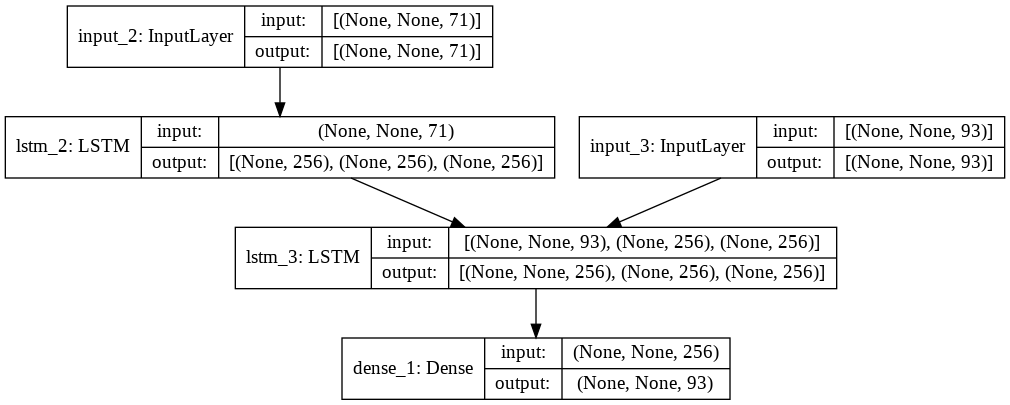

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
## Train the model

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
    )

# Save model
model.save("s2s")

## 1エポック30秒前後、5エポックで計2分半くらいかかる

Epoch 1/5
32/32 [==============================] - 31s 875ms/step - loss: 2.1113 - accuracy: 0.6428 - val_loss: 1.3338 - val_accuracy: 0.6973
Epoch 2/5
32/32 [==============================] - 27s 842ms/step - loss: 1.1196 - accuracy: 0.7356 - val_loss: 1.1219 - val_accuracy: 0.7073
Epoch 3/5
32/32 [==============================] - 27s 846ms/step - loss: 1.0013 - accuracy: 0.7437 - val_loss: 1.0630 - val_accuracy: 0.7121
Epoch 4/5
32/32 [==============================] - 27s 847ms/step - loss: 0.9557 - accuracy: 0.7462 - val_loss: 1.0131 - val_accuracy: 0.7149
Epoch 5/5
32/32 [==============================] - 27s 845ms/step - loss: 0.8887 - accuracy: 0.7567 - val_loss: 0.9452 - val_accuracy: 0.7356


INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


#### <font color = green> **3.3.** </font> Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [ ]:
## Define sampling models
# Restore the model and construct the encoder and decoder.

model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

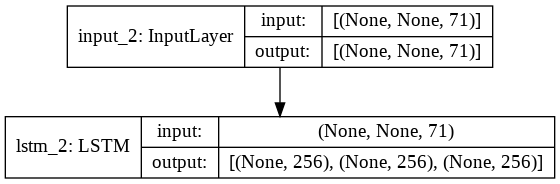

In [ ]:
keras.utils.plot_model(encoder_model, show_shapes=True)

In [ ]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_4")  # 3->4
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_5")  # 4->5
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
    )
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )

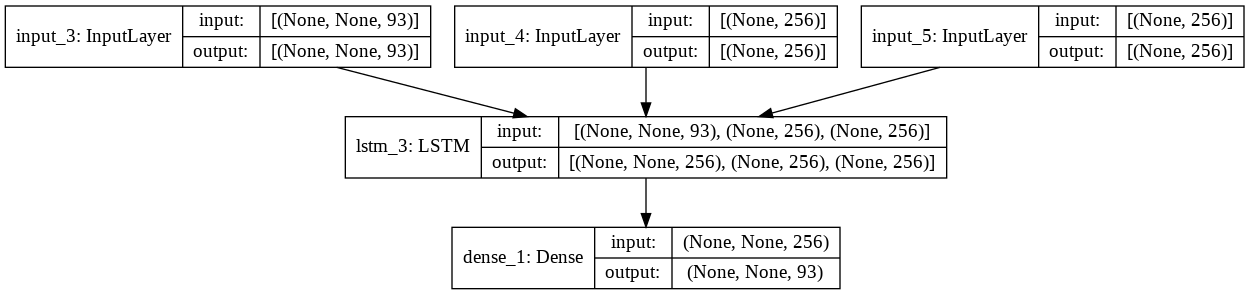

In [ ]:
keras.utils.plot_model(decoder_model, show_shapes=True)

In [ ]:
# Reverse-lookup token index to decode sequences back to something readable.

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  # Populate the first character of target sequence with the start character.
  target_seq[0, 0, target_token_index["\t"]] = 1.0

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  stop_condition = False
  decoded_sentence = ""
  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char

    # Exit condition: either hit max length or find stop character.
    if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
      stop_condition = True

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.0

    # Update states
    states_value = [h, c]
  return decoded_sentence

In [ ]:
## You can now generate decoded sentences as such:

for seq_index in range(20):
  # Take one sequence (part of the training set) for trying out decoding.
  input_seq = encoder_input_data[seq_index : seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print("-")
  print("Input sentence:", input_texts[seq_index])
  print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Je s                                                        
-
Input sentence: Go.
Decoded sentence: Je s                                                        
-
Input sentence: Go.
Decoded sentence: Je s                                                        
-
Input sentence: Hi.
Decoded sentence: Je s                                                        
-
Input sentence: Hi.
Decoded sentence: Je s                                                        
-
Input sentence: Run!
Decoded sentence: Soss                                                        
-
Input sentence: Run!
Decoded sentence: Soss                                                        
-
Input sentence: Run!
Decoded sentence: Soss                                                        
-
Input sentence: Run!
Decoded sentence: Soss                                                        
-
Input sentence: Run!
Decoded sentence: Soss                                          

### <font color = blue>**4.** </font> アテンションを用いたニューラル機械翻訳

Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

このノートブックでは、スペイン語から英語への翻訳を行う Sequence to Sequence (seq2seq) モデルを訓練します。

このチュートリアルは、 Sequence to Sequence モデルの知識があることを前提にした上級編のサンプルです。

このノートブックのモデルを訓練すると、_"¿todavia estan en casa?"_  のようなスペイン語の文を入力して、英訳：  _"are you still at home?"_  を得ることができます。

この翻訳品質はおもちゃとしてはそれなりのものですが、生成されたアテンションの図表の方が面白いかもしれません。

これは、翻訳時にモデルが入力文のどの部分に注目しているかを表しています。

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: このサンプルは P100 GPU 1基で実行した場合に約 10 分かかります。

#### <font color = green> **4.1.** </font> データセットのダウンロードと準備

http://www.manythings.org/anki/ で提供されている言語データセットを使用します。

このデータセットには、次のような書式の言語翻訳ペアが含まれています。

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

さまざまな言語が用意されていますが、ここでは英語ースペイン語のデータセットを使用します。

利便性を考えてこのデータセットは Google Cloud 上に用意してありますが、ご自分でダウンロードすることも可能です。

データセットをダウンロードしたあと、データを準備するために下記のようないくつかの手順を実行します。

1. それぞれの文ごとに、*開始* と *終了* のトークンを付加する
2. 特殊文字を除去して文をきれいにする
3. 単語インデックスと逆単語インデックス（単語 → id と id → 単語のマッピングを行うディクショナリ）を作成する
4. 最大長にあわせて各文をパディングする

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
# ファイルのダウンロード

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [ ]:
# ユニコードファイルを ascii に変換
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # 単語とそのあとの句読点の間にスペースを挿入
  # 例：　"he is a boy." => "he is a boy ."
  # 参照：- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # (a-z, A-Z, ".", "?", "!", ",") 以外の全ての文字をスペースに置き換え
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.rstrip().strip()

  # 文の開始と終了のトークンを付加
  # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
# 1. アクセント記号を除去
# 2. 文をクリーニング
# 3. [ENGLISH, SPANISH] の形で単語のペアを返す

def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [ ]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # クリーニングされた入力と出力のペアを生成
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
## データセットのサイズを制限（オプション）

num_examples = 10000  ### 30000 -> 10000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [ ]:
# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

8000 8000 2000 2000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
454 ----> mama
12 ----> esta
287 ----> trabajando
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
574 ----> mom
9 ----> s
278 ----> working
3 ----> .
2 ----> <end>


In [ ]:
## tf.data データセットの作成

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 12]), TensorShape([64, 8]))

#### <font color = green> **4.2.** </font> エンコーダー・デコーダーモデルの記述

下図は、入力の単語ひとつひとつにアテンション機構によって重みが割り当てられ、それを使ってデコーダーが文中の次の単語を予測することを示しています。

下記の図と式は [Luong の論文](https://arxiv.org/abs/1508.04025v5) にあるアテンション機構の例です。

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

入力がエンコーダーを通過すると、

shape が *(batch_size, max_length, hidden_size)* のエンコーダー出力と、

shape が *(batch_size, hidden_size)* のエンコーダーの隠れ状態が得られます。

下記に実装されている式を示します。

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

このチュートリアルでは、エンコーダーでは [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) を使用します。

簡略化した式を書く前に、表記方法を定めましょう。

* FC = 全結合 (Dense) レイヤー
* EO = エンコーダーの出力
* H = 隠れ状態
* X = デコーダーへの入力

擬似コードは下記のとおりです。

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`　softmax は既定では最後の軸に対して実行されますが、スコアの shape が *(batch_size, max_length, hidden_size)*　であるため、*最初の軸* に適用します。`max_length` は入力の長さです。入力それぞれに重みを割り当てようとしているので、softmax はその軸に適用されなければなりません。
* `context vector = sum(attention weights * EO, axis = 1)`. 上記と同様の理由で axis = 1 に設定しています。
* `embedding output` = デコーダーへの入力 X は Embedding レイヤーを通して渡されます。
* `merged vector = concat(embedding output, context vector)`
* この結合されたベクトルがつぎに GRU に渡されます。

それぞれのステップでのベクトルの shape は、コードのコメントに指定されています。

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 12, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # スコアを計算するためにこのように加算を実行する
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # スコアを self.V に適用するために最後の軸は 1 となる
    # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights の shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector の合計後の shape == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 12, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # アテンションのため
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output の shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 結合したベクトルを GRU 層に渡す
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2306)


In [ ]:
## オプティマイザと損失関数の定義

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
## チェックポイント（オブジェクトベースの保存）

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

#### <font color = green> **4.3.** </font> 学習の実行

1. *入力* を *エンコーダー* に通すと、*エンコーダー出力* と *エンコーダーの隠れ状態* が返される
2. エンコーダーの出力とエンコーダーの隠れ状態、そしてデコーダーの入力（これが *開始トークン*）がデコーダーに渡される
3. デコーダーは *予測値* と *デコーダーの隠れ状態* を返す
4. つぎにデコーダーの隠れ状態がモデルに戻され、予測値が損失関数の計算に使用される
5. デコーダーへの次の入力を決定するために *Teacher Forcing* が使用される
6. *Teacher Forcing* は、*正解単語* をデコーダーの *次の入力* として使用するテクニックである
7. 最後に勾配を計算し、それをオプティマイザに与えて誤差逆伝播を行う

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher Forcing - 正解値を次の入力として供給
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      # Teacher Forcing を使用
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [ ]:
EPOCHS = 2 ### 10 -> 2

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
  # 2 エポックごとにモデル（のチェックポイント）を保存
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  ## 1エポック4分前後かかる

Epoch 1 Batch 0 Loss 5.0665
Epoch 1 Batch 100 Loss 2.2342
Epoch 1 Loss 2.6152
Time taken for 1 epoch 245.7692666053772 sec

Epoch 2 Batch 0 Loss 2.0361
Epoch 2 Batch 100 Loss 1.7193
Epoch 2 Loss 1.8686
Time taken for 1 epoch 234.06488823890686 sec

Epoch 3 Batch 0 Loss 1.6050
Epoch 3 Batch 100 Loss 1.5435
Epoch 3 Loss 1.5662
Time taken for 1 epoch 233.89911699295044 sec

Epoch 4 Batch 0 Loss 1.4026
Epoch 4 Batch 100 Loss 1.3188
Epoch 4 Loss 1.3642
Time taken for 1 epoch 233.4871907234192 sec



#### <font color = green> **4.4.** </font> 翻訳

* 評価関数は、*Teacher Forcing* を使わないことを除いては、訓練ループと同様である。タイムステップごとのデコーダーへの入力は、過去の予測値に加えて、隠れ状態とエンコーダーのアウトプットである。
* モデルが *終了トークン* を予測したら、予測を停止する。
* また、*タイムステップごとのアテンションの重み*　を保存する。

Note: エンコーダーの出力は 1 つの入力に対して 1 回だけ計算されます。

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    # 後ほどプロットするためにアテンションの重みを保存
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # 予測された ID がモデルに戻される
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
## checkpoint_dir の中の最後のチェックポイントを復元しテストする

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s a good . <end> 


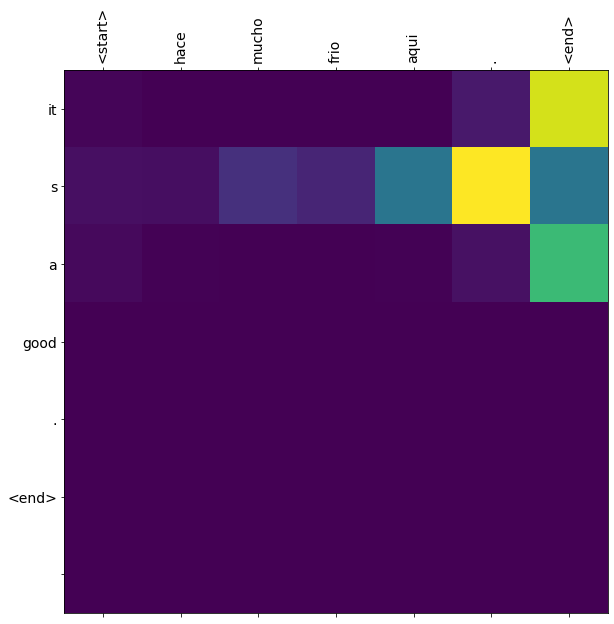

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my car . <end> 


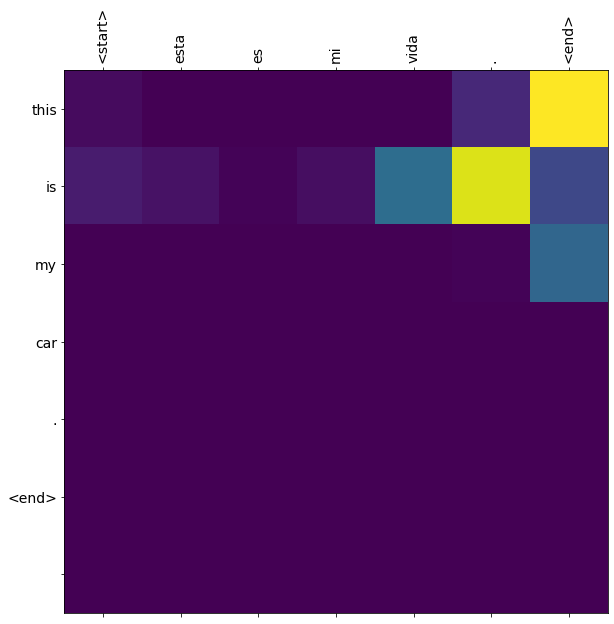

In [ ]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: can you know it ? <end> 


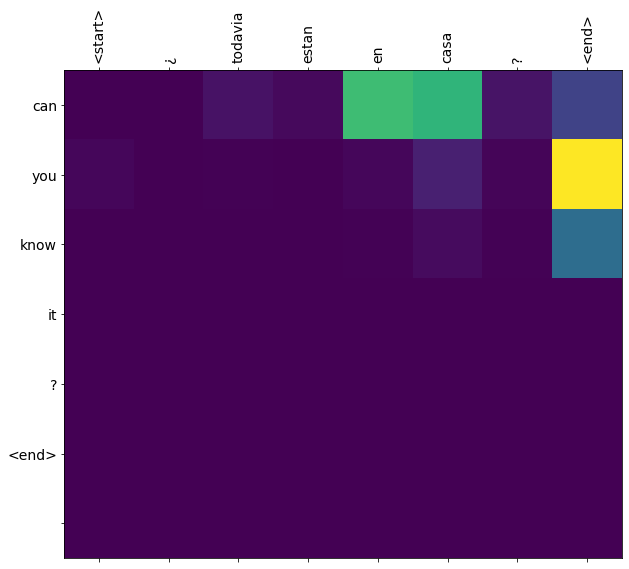

In [ ]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: we ve seen it . <end> 


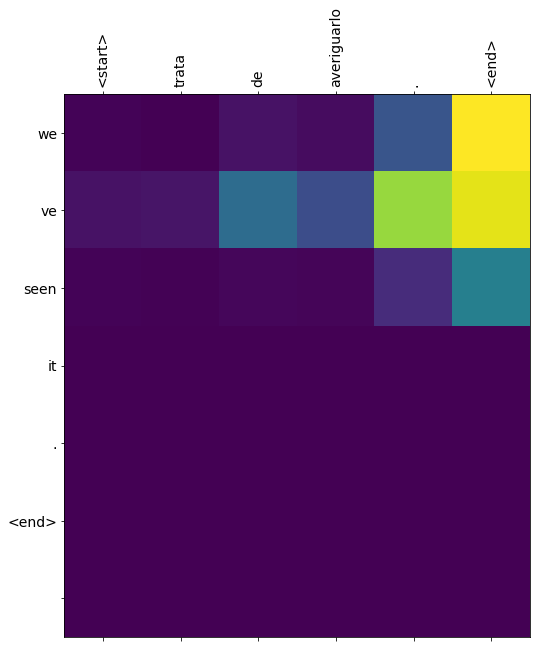

In [ ]:
# 翻訳あやまりの例
translate(u'trata de averiguarlo.')

#### <font color = green> **4.5.** </font> 次のステップ

* [異なるデータセットをダウンロード](http://www.manythings.org/anki/)して翻訳の実験を行ってみよう。たとえば英語からドイツ語や、英語からフランス語。
* もっと大きなデータセットで訓練を行ったり、もっと多くのエポックで訓練を行ったりしてみよう。